<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Bayesian Estimation and Regression with `pymc3`

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Describe how to use pymc3 to fit Bayesian estimation models
- Run the Bayesian alternative to a t-test using pymc3
- Plot and interpret the results of pymc3 models
- Construct a Bayesian regression using pymc3
- Use the patsy-style formula syntax to build a pymc3 regression


### Lesson Guide
- [Introduction](#intro)
- [Enter `pymc3`](#pymc3)
- [Load the Starcraft data](#data)
- [Alternative to t-testing using Bayesian estimation](#ttest)
    - [Get the APM values for 19 and 26 year olds](#load)
    - [Perform a Frequentist t-test of the mean APM difference between groups.](#freq-ttest)
    - [Set up a Bayesian model with priors on the mean APMs](#priors)
    - [Construct the prior distributions on the means](#construct-priors)
    - [Construct the prior distributions on the standard deviations](#std-priors)
    - [Set up the APM distributions for the two groups](#apm-dists)
    - [Tracking additional metrics](#metrics)
    - [Fitting the `pymc3` model](#fit)
    - [Plotting the posteriors and metric distributions](#plotting)
- [Bayesian regression with `pymc3`](#reg)
    - [Set up variables to perform an age vs. APM regression](#age-vs-apm)
    - [Set up the Bayesian regression model](#bayes-model)
    - [Plot the posteriors using `pm.traceplot`](#traceplot)
- [Using a patsy-style formula to specify a `pymc3` model](#formula)

<a id='intro'></a>
## Introduction
---

With `pymc3` we can perform the Bayesian counterparts of Frequentist models we have studied. In this codealong lesson we will start incrementally: first by repeating the Beta-Binomial model from yesterday, then replacing the Frequentist t-test with Bayesian estimation and finally performing a Bayesian regression with a single predictor.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='pymc3'></a>
## Enter `pymc3`
---

The `pymc3` is the Bayesian modeling package we will be using. It is a powerful and flexible architecture for performing a huge variety of Bayesian analyses. We will only be scratching the surface today.

> **Note:** There is also `pymc` (or pymc2) which has a different syntax. pymc2 is (in my opinion) harder for beginners to Bayesian statistics to understand; pymc3 bridges the gap better for those who are more familiar with constructing models using Frequentist style models/syntax.

Let's start with the website subscription example.  Say from previous experience, I observed 345 subscriptions out of a total of 1000 visits.  My new data shows 40 subscriptions out of 100 visits.

In [3]:
n_success_prior = 345         # say, from "historical" data
n_failures_prior = 1000-345

n = 100  # new data, total
k = 40   # successes
mle_p = k/n
print(mle_p)

0.4


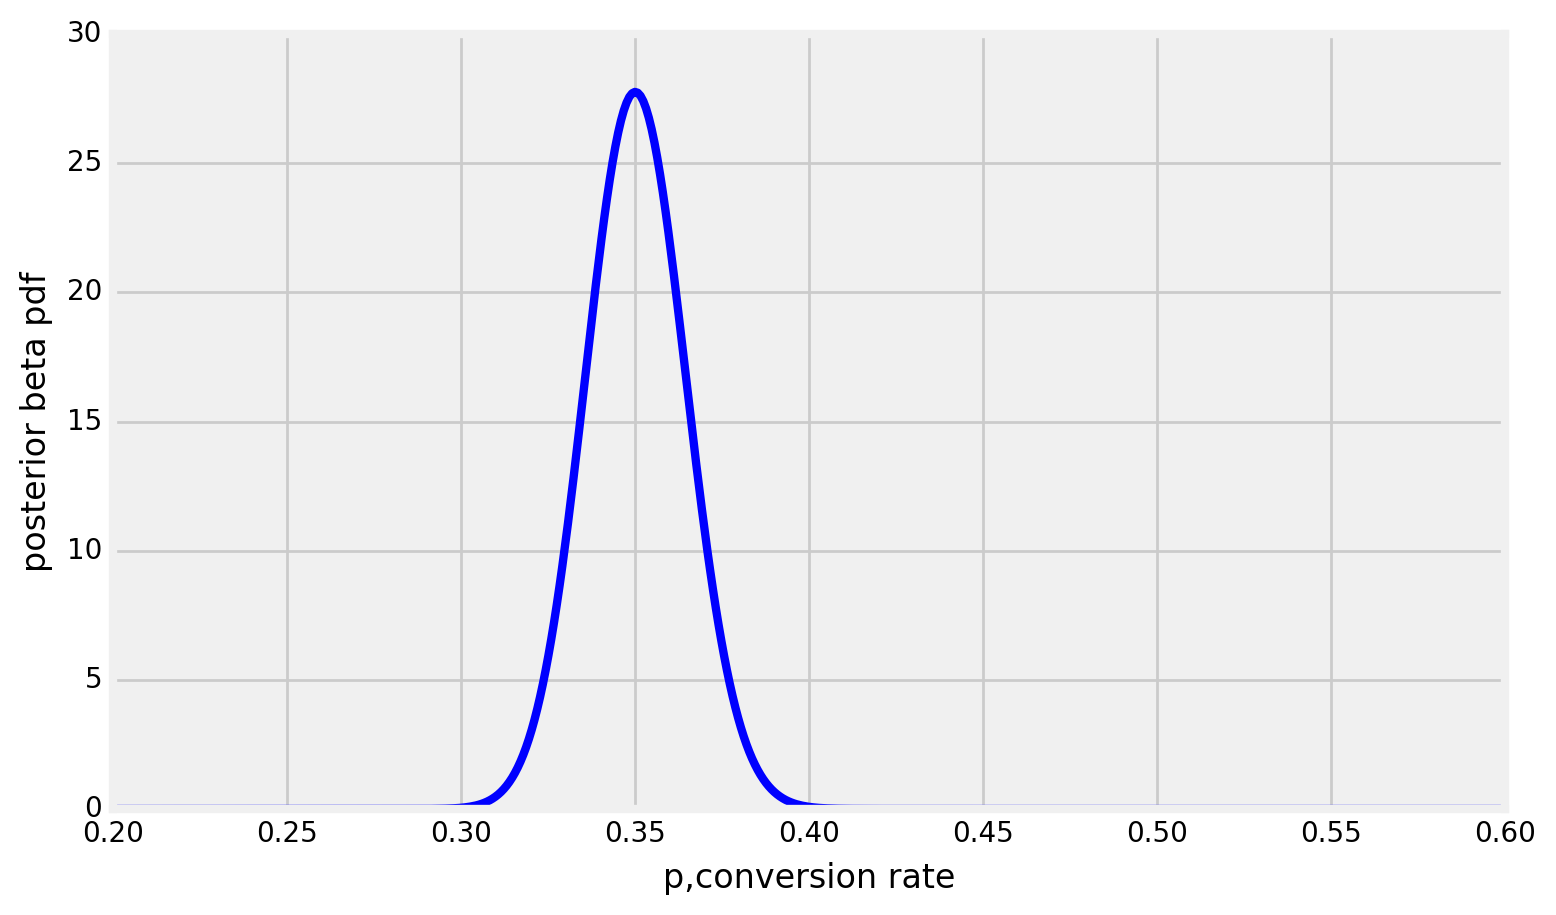

In [4]:
import scipy.stats as stats
alpha_prior=n_success_prior+1
beta_prior=n_failures_prior+1

alpha_post=k+alpha_prior
beta_post=n-k+beta_prior
# Calculate the posterior Beta distribution and plot
pvals=np.linspace(0.2,0.6,500)
beta_dist=stats.beta(alpha_post,beta_post)

fig,ax=plt.subplots(figsize=(8,5))
ax.plot(pvals,beta_dist.pdf(pvals),'b',lw=3)
ax.set_xlabel('p,conversion rate')
ax.set_ylabel('posterior beta pdf')

In [1]:
import pymc3 as pm


//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [7]:
with pm.Model() as model:
    p=pm.Beta('p',alpha=alpha_prior,beta=beta_prior)
    y=pm.Binomial('y',n=n,p=p,observed=k)
    trace=pm.sample(2000,tune=1000,njobs=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3000/3000 [00:04<00:00, 738.16it/s]


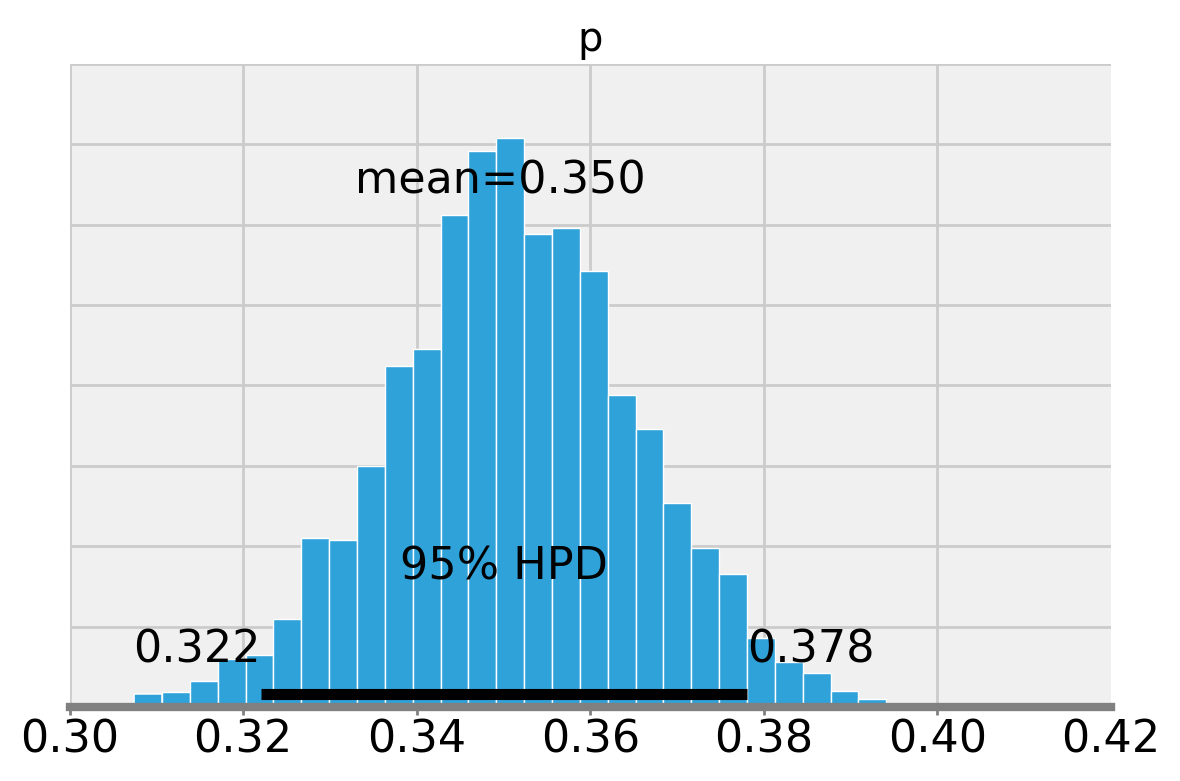

In [8]:
pm.plot_posterior(trace[200:],varnames='p')

<a id='data'></a>
### Load the Starcraft dataset
---

You may be familiar with this dataset. It has records of different player statistics in competitive Starcraft. There are a variety of columns that are described in detail within the `description.txt` file contained inside the `./datasets/` folder.

For the examples in this lab, I will be using APM (actions per minute) and Age, but I in the following lab you will get the chance to look at other variables as well.

In [9]:
star = pd.read_csv('./datasets/SkillCraft1_Dataset.csv')

In [4]:
# A:

<a id='ttest'></a>
## Alternative to t-testing using Bayesian estimation
---

[This example is adapted from the documentation here.](http://pymc-devs.github.io/pymc3/notebooks/BEST.html) 

> *Note: In that example the Student t distribution is used instead of the normal distribution like I use below. This is more appropriate, but more complicated due to the parameterization of the t-distribution. If you're feeling bold try doing this with the t-distribution like in the documentation!

In the following code, I will be using Bayesian posterior estimation to look at the difference in APM between 19 year old players and 26 year old players.

### The Frequentist strategy
In Frequentist statistics, calculating the mean difference between groups is typically done with a t-test. In a t-test we state a null hypothesis (H0) that there is no diffference between groups, then evaluate the probability that we could have gotten this data when the null hypothesis is true.

The de-facto standard for statistically comparing two (or more) samples is to use a statistical test. This involves expressing a null hypothesis, which typically claims that there is no difference between the groups, and using a chosen test statistic to determine whether the distribution of the observed data is plausible under the hypothesis. This rejection occurs when the calculated test statistic is higher than some pre-specified threshold value.

> In the frequentist approach, the _sampling distribution_ is approximated from the mean and standard error.

### The Bayesian strategy
The Bayesian approach for evaluating differences between groups is "estimation" rather than "testing". Instead of asking "are the two groups different?", we instead ask "_how_ different are the two groups?" This is the subtle difference in estimation as opposed to testing. We are measuring the extent of the difference between the groups, whether it be zero or any other value.

For a more detailed treatment feel free to read the documentation linked above.

> In the Bayesian approach, the _sampling distribution_ is approximated through repeated sampling.

<a id='load'></a>
### Get the APM for 19 and 26 year olds

In [5]:
# A:

**Calculate the mean for the two groups and the empirical difference between means.**

In [6]:
# A:

<a id='freq-ttest'></a>
### Perform a Frequentist t-test of the mean APM difference between groups.

What is the null hypothesis? What is the alternative hypothesis?

In [7]:
import scipy.stats as stats

In [8]:
# A:

**Plot the t-statistic for the test on the t-distribution.**

In [9]:
# A:

**What is the p-value?**

In [10]:
# A:

From the `pymc3` docs (http://docs.pymc.io/notebooks/BEST.html):

> Unfortunately, it is not easy to conduct hypothesis tests correctly, and their results are very easy to misinterpret. Setting up a statistical test involves several subjective choices (e.g. statistical test to use, null hypothesis to test, significance level) by the user that are rarely justified based on the problem or decision at hand, but rather, are usually based on traditional choices that are entirely arbitrary (Johnson 1999). The evidence that it provides to the user is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999).

<a id='priors'></a>
### Set up the bayesian model with priors on mean APMs

Next we'll go through the steps of the Bayesian estimation of the difference between means using `pymc3`.

First we find the mean and standard deviation of APM regardless of age group. We can going to use these values to inform our prior belief about APM.

In [11]:
# A:

<a id='construct-priors'></a>
### Construct the prior distributions on the means

> **Note**: `pymc3` sets up models using the Python `with ... :` syntax.

The first thing we are going to set up is our prior belief about the mean APM for our 19 year olds and 26 year olds. _These are not fixed values,_ but rather normal distributions covering a range of possible values for the mean APM for each group with varying likelihoods.

We are going to set up the normal distributions to both take the overall mean and standard deviation of the actions per minute for all players. In other words, our prior belief for each group's mean APM is the same.

In [12]:
# A:

<a id='std-priors'></a>
### Priors on standard deviations

What we set up before are the prior distributions for the _means_ of APM for the two age groups, but we can also set up priors on the standard deviations for APM for each group.

Our standard deviation priors can be "uninformative": uniformly distributed from close to 0 up to 100. We are saying that we believe all standard deviations in those ranges to be equally likely.

In [13]:
# A:

<a id='apm-dists'></a>
### Set up the APM distributions for the two groups

Now that we have our prior beliefs about the mean and standard deviation of APM for each age group, we can construct what will be the posterior distributions for the APMs after "observing" the data.

For each group we set up a `pm.Normal` distribution to represent the likelihood of the observed APM data. The mean `mu=` will be our prior belief distribution of the mean for that group. Likewise the `sd=` will be the prior distribution for standard deviation of APM for that group. 

Lastly, we provide the vectors of data for the `observed=` parameter. This is the actual, measured APM data. When we "fit" this model (using MCMC or another sampling strategy under the hood), the posterior distributions will be updated according to our prior beliefs and our data – just like in Bayes formula!

In [14]:
# A: 

<a id='metrics'></a>
### Tracking additional metrics

The last thing we'll do before fitting the model is define some distributions that will make it easier for us to evaluate the difference between mean APMs of the two groups. 

`pm.Deterministic` distributions are defined from other distributions in the model. For example, we can set up `diff_of_means` to be defined by `group19_mean - group26_mean`, making this a distribution of the differences between means between groups as the posteriors are iteratively fit/estimated.

We can also set up a distribution for the efect size by taking the difference between means and dividing by the pooled standard deviation.

In [15]:
# A:

<a id='fit'></a>
### Fitting the `pymc3` model

When we call `trace = pm.sample(...)` we are starting a sampling process to estimate the posterior distribution. `pymc3` has the option to do MCMC, but defaults to the NUTS sampler. NUTS stands for No U-Turn Sampler and is a state-of-the-art posterior estimation algorithm.

The "trace" is a collection of all the values on the posterior distribution "visited" during the sampling procedure. The values in the trace define the posterior distribution.

In [16]:
# A:

<a id='plotting'></a>
### Plotting the posteriors and metric distributions

`pymc3` comes with convenient methods for plotting posteriors. Below we plot our posterior means and standard deviations. The relevant statistics about the distributions are automatically added to the plots.

The HPD is the Highest Posterior Density interval. This gives us a Bayesian "credible interval" which is the corollary to the Frequentist confidence interval. The 95% HPD says that the 95% highest density points on the distribution fall within that range.

**Take a look at the first element of the `trace`:**

In [17]:
# A:

**Use the `pm.plot_posterior` function to look at the posterior distributions for the group means and standard deviations.**

> **Note:** It is common to slice off the initial portion of the trace. This is known as the "burn-in". The sampling procedure often starts far away from the correct estimates, and so slicing off the beginning can get rid of the cruft. It is also common to not take every sample, but skip every two or three. I am not doing that here.

In [18]:
# A:

**Plot the posteriors of our metric distributions.**

In [19]:
# A:

**The `pm.summary` function can also display a text representation of this information:**

In [20]:
# A:

<a id='reg'></a>
## Bayesian regression with `pymc3`
---

With `pymc3`, the sky is the limit. Let's move on to something a little more complicated: Bayesian regressions.

> *Note: [This example is modeled after the generalized linear model (GLM) instructions in the pymc3 documentation.](http://pymc-devs.github.io/pymc3/notebooks/GLM-linear.html)*

What are the benefits to taking a Bayesian approach to regression modeling? Just like in our estimation of means per group, when we perform regression with Bayesian statistics we will get out posterior *distributions* on our intercept and coefficients. 

This is a big difference from the point estimates coming out of the Frequentist regression: not only do we have the most likely value for the coefficients (the MAP estimates), we can see the range of possibilities given our prior and observed data. 

---

<a id='age-vs-apm'></a>
### Set up variables to perform an age vs. APM regression

In [21]:
# A:

**Plot out the age vs. apm values.**

In [22]:
# A:

<a id='bayes-model'></a>
### Setting up the Bayesian regression model

Remember regression?

## $$y = \beta_0 + \beta_1 x + \epsilon$$

From a statistical perspective, $\beta_0$, $\beta_1$ and $\epsilon$ are random variables.

For the sake of simplicity, let's assume that they are _uniform_ random variables.  This will be our prior belief, that will be updated based on data!

## $$\beta_0 \sim Uniform(0.0001, 1000)$$

## $$\beta_1 \sim Uniform(-10000, 10000)$$

## $$\epsilon \sim Uniform(-200, 200)$$


---

Like before, we will construct our model with the `with pm.Model() ...` syntax. 

We have three prior distributions in this case that will be updated to posteriors given our observed data:

1. `apm_std`: which will be our prior belief about the standard deviation of APM values. In this case I am setting it to be uniform (uninformative) between `0.0001`, and `1000.`
- `intercept`: a uniform distribution for the range of possible values of the intercept.
- `age_beta`: a uniform distribution for the range of possible values of the age coefficient.

We set up a `likelihood` distribution that is also normal, representing the distribution of the data (APM) given our predictor. The mean of the likelihood is defined like a regression formula: our intercept distribution plus the age values times our age beta distribution. We give the `apm_std` uniform prior as the standard deviation. Lastly, the observed values, or data, will be the APM values.

What will happen here as we sample from the posterior is that more likely values (as defined by the `mu=` regression-style definition) will be "visited" more often. The intercept and age_beta distributions will have more values visited in places where they result in higher likelihood estimates.

`pm.find_MAP()` tries to find good starting values for our sampling procedure so that we don't have to run it for as many iterations to get a good posterior representation.

In [23]:
# A:

<a id='traceplot'></a>
### Plot the posteriors using `pm.traceplot`

The traceplot function can also plot our posteriors, as well as a graph of the actual traces for each distribution. These traces represent the points visited by the sampling algorithm.

In [24]:
# A:

<a id='formula'></a>
## Setting up a model using a patsy-style formula
---

`pymc3` also provides a convenience function `pm.glm.glm(...` which takes a patsy-style formula definition and the dataframe, then automatically constructs the distributions required to solve the Bayesian regression. Pretty nice.

In [25]:
# A:

**Lastly, you can plot out different possible regression lines with `pm.glm.plot_posterior_predictive`.**

This function takes:

- the trace (MCMC samples)
- the number of samples you want to draw out and plot
- an `lm=` argument that will be a function defining how the regression line will be fit using an x value and the sample
- an `eval=` argument that will be the x-values `lm` is evaluated over

In [26]:
# A: